# Import

In [148]:
import pandas as pd
from src.Backtester.backtester import Backtester
from datamodel import Listing
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools
import os
from tqdm import tqdm
import importlib
import src.Backtester.Round_1.trader

importlib.reload(src.Backtester.Round_1.trader)

from src.Backtester.Round_1.trader import Trader

# Data

In [149]:
def get_prices(round: int, day: int):

    path = f"../../data/round{round}/prices_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"../../data/round{round}/trades_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")

price_frames = []
trade_frames = []

for day in range(-2, 1):

    prices = get_prices(1, day)
    trades = get_trades(1, day)
    price_frames.append(prices)
    trade_frames.append(trades)

prices = pd.concat(price_frames, ignore_index=True)
trades = pd.concat(trade_frames, ignore_index=True)

# Backtest

In [190]:
trader = Trader()

# optimized

import src.Backtester.Round_1.traderv04

importlib.reload(src.Backtester.Round_1.traderv04)

from src.Backtester.Round_1.traderv04 import Trader

trader_opt = Trader()

position_limit = {
    "RAINFOREST_RESIN": 50,
    "KELP": 50,
    "SQUID_INK": 50

}
listings = {
    "RAINFOREST_RESIN": Listing("RAINFOREST_RESIN", "RAINFOREST_RESIN", "SEASHELLS"),
    "KELP": Listing("KELP", "KELP", "SEASHELLS"),
    "SQUID_INK": Listing("SQUID_INK", "SQUID_INK", "SEASHELLS"),
}


fair_marks = {
    "KELP": lambda order_depth: trader.kelp_fair_value(order_depth, {}),
    "SQUID_INK": lambda order_depth: trader.squid_ink_fair_value(order_depth, {})
}

#prices = pd.read_csv("../../data/round1/prices_round_1_day_-2.csv", delimiter=';')
#trades = pd.read_csv("../../data/round1/trades_round_1_day_-2.csv", delimiter=';')


bt = Backtester(
    trader=trader_opt,
    listings=listings,
    position_limit=position_limit,
    fair_marks=fair_marks,
    market_data=prices,  # your loaded pandas DataFrame
    trade_history=trades,  # your loaded pandas DataFrame
    file_name="../../data/tutorial/backtest_results.txt"
)

bt.run()

In [191]:
bt.pnl

{'RAINFOREST_RESIN': 31876.0, 'KELP': 9053.5, 'SQUID_INK': 19085.0}

# Backtest Analysis

In [152]:
def preprocess_data(orderbook, trades):
    orderbook = orderbook[['timestamp', 'product', 'mid_price']]
    trades = trades[['timestamp', 'symbol', 'price']]
    
    merged = trades.merge(orderbook, left_on=['timestamp', 'symbol'], right_on=['timestamp', 'product'], how='left')
    merged.drop(columns=['product'], inplace=True)
    
    return merged

def calculate_reversion_beta(data):
    data['spread'] = data['price'] - data['mid_price']
    
    data['spread_lag'] = data['spread'].shift(1)
    data.dropna(inplace=True)
    
    # Linear regression spread(t) = beta * spread(t-1)
    X = sm.add_constant(data['spread_lag'])  
    y = data['spread']
    model = sm.OLS(y, X).fit()
    
    return model.params['spread_lag'], model.summary()


data = preprocess_data(prices[prices['product'] == 'KELP'], trades[trades['symbol'] == 'KELP'])
reversion_beta, summary = calculate_reversion_beta(data)

print(f"Reversion Beta: {reversion_beta}")
print(summary)

Reversion Beta: 0.2538173572688437
                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1819.
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:28:37   Log-Likelihood:            -1.0671e+05
No. Observations:               26411   AIC:                         2.134e+05
Df Residuals:                   26409   BIC:                         2.134e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.

In [153]:
kelp_data = prices[prices['product'] == 'KELP'].reset_index(drop=True)

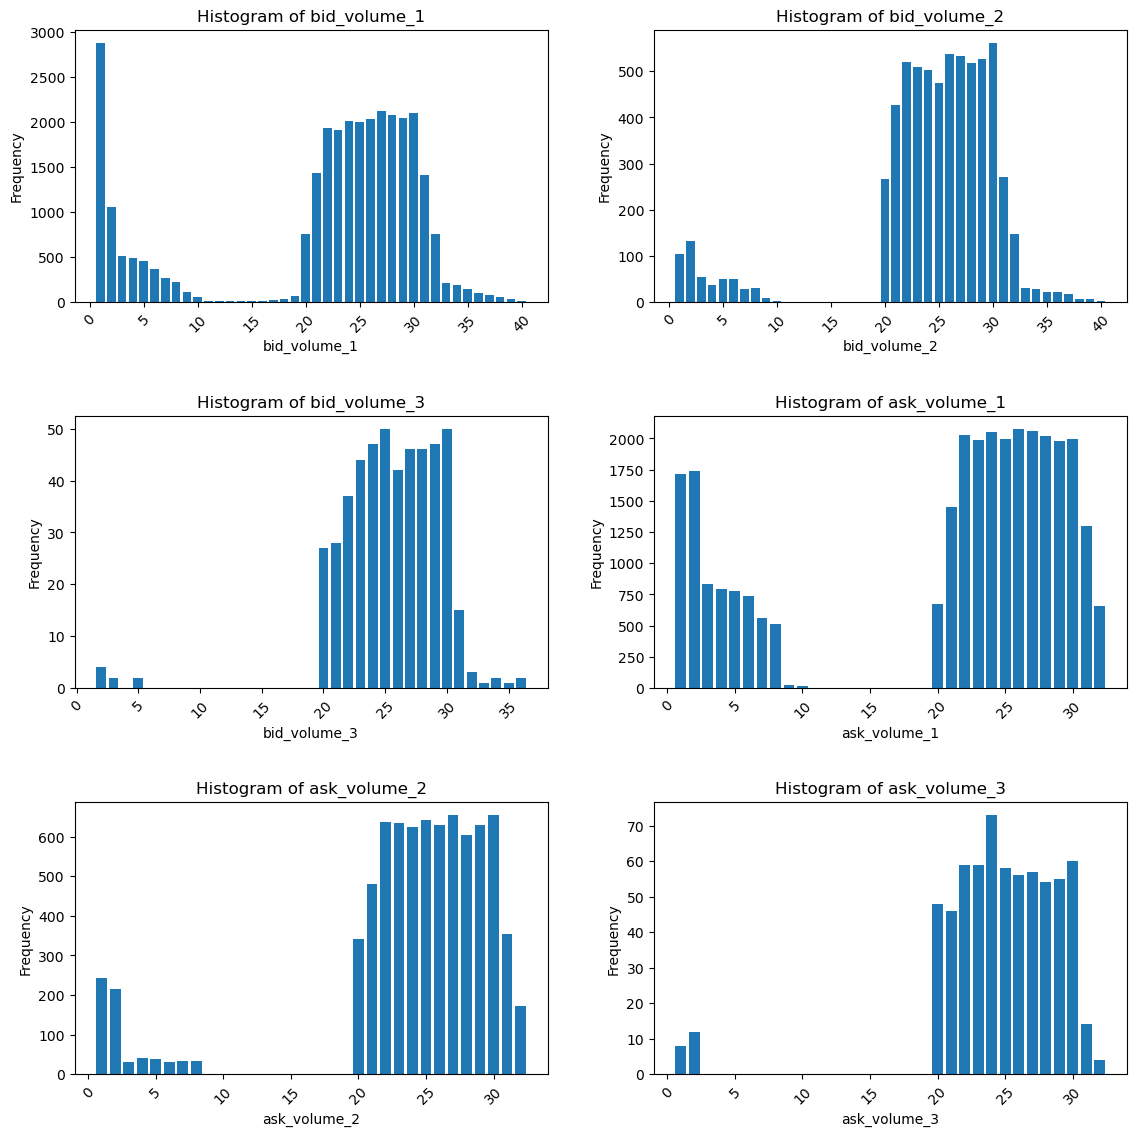

In [154]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = kelp_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show()

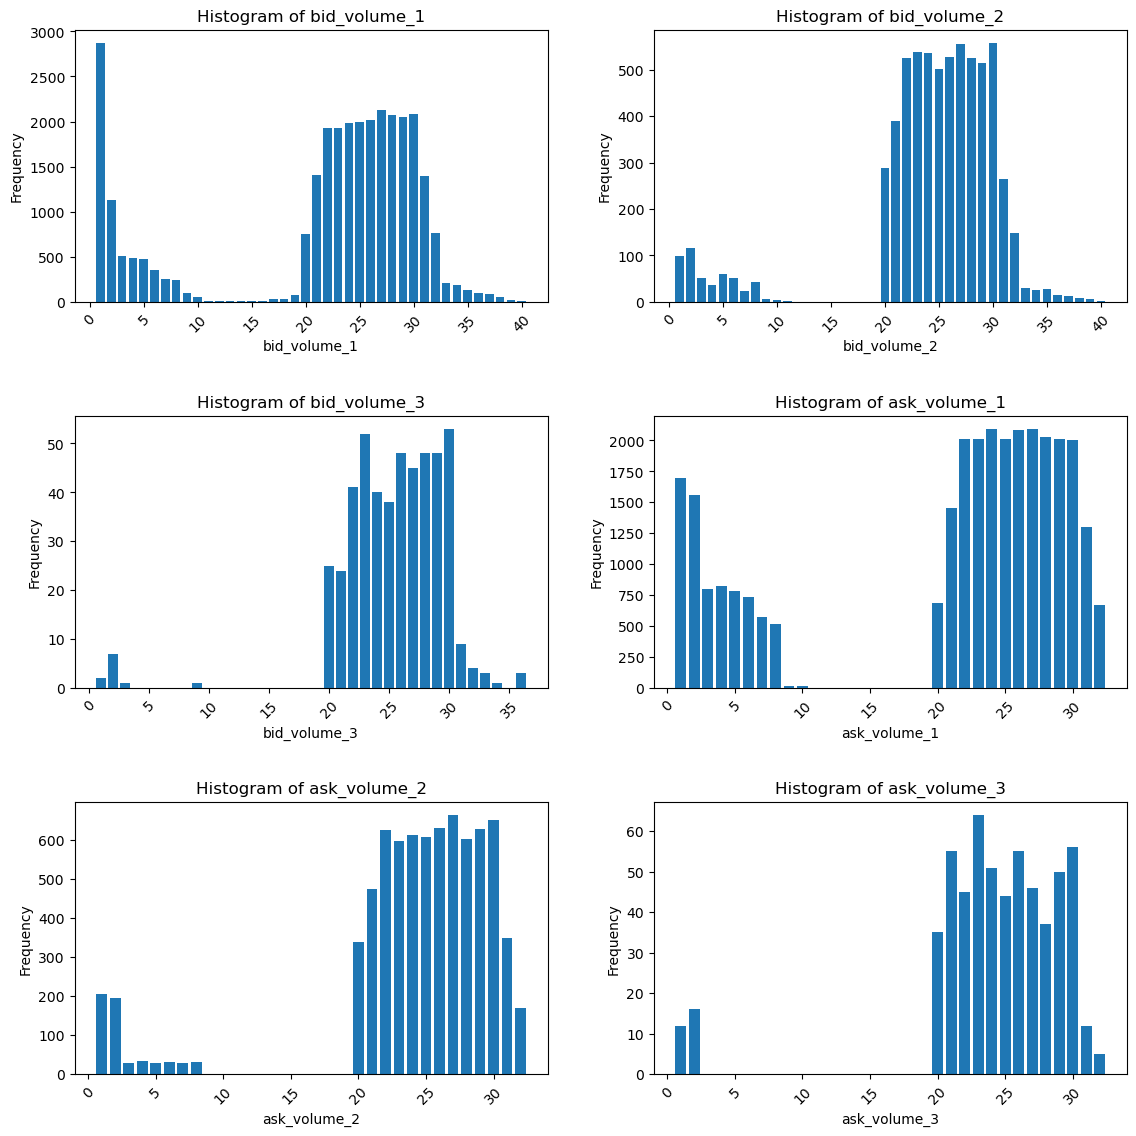

In [155]:
plt.figure(figsize=(12, 4 * num_rows))

ink_data = prices[prices['product'] == 'SQUID_INK'].reset_index(drop=True)

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = ink_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show()

In [156]:
data = preprocess_data(prices[prices['product'] == 'SQUID_INK'], trades[trades['symbol'] == 'SQUID_INK'])
reversion_beta, summary = calculate_reversion_beta(data)

print(f"Reversion Beta: {reversion_beta}")
print(summary)

Reversion Beta: 0.24948380241264423
                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1759.
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:28:38   Log-Likelihood:            -1.5683e+05
No. Observations:               26510   AIC:                         3.137e+05
Df Residuals:                   26508   BIC:                         3.137e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

# Grid Search

In [157]:
def generate_param_combinations(param_grid):
    param_names = param_grid.keys()
    param_values = param_grid.values()
    combinations = list(itertools.product(*param_values))
    return [dict(zip(param_names, combination)) for combination in combinations]

In [158]:
def run_backtests(trader, listings, position_limit, fair_marks, market_data, trade_history, backtest_dir, param_grid, symbol):
    if not os.path.exists(backtest_dir):
        os.makedirs(backtest_dir)

    param_combinations = generate_param_combinations(param_grid[symbol])

    results = []
    for params in tqdm(param_combinations, desc=f"Running backtests for {symbol}", unit="backtest"):
        trader.params = {symbol: params}
        backtester = Backtester(trader, listings, position_limit, fair_marks, market_data, trade_history)
        backtester.run()

        param_str = "-".join([f"{key}={value}" for key, value in params.items()])
        log_filename = f"{backtest_dir}/{symbol}_{param_str}.log"
        backtester._log_trades(log_filename)

        results.append((params, backtester.pnl[symbol]))

    return results

In [159]:
def calculate_kelp_fair(order_depth):
    # assumes order_depth has orders in it 
    best_ask = min(order_depth.sell_orders.keys())
    best_bid = max(order_depth.buy_orders.keys())
    filtered_ask = [price for price in order_depth.sell_orders.keys() if abs(order_depth.sell_orders[price]) >= 15]
    filtered_bid = [price for price in order_depth.buy_orders.keys() if abs(order_depth.buy_orders[price]) >= 15]
    mm_ask = min(filtered_ask) if len(filtered_ask) > 0 else best_ask
    mm_bid = max(filtered_bid) if len(filtered_bid) > 0 else best_bid

    mmmid_price = (mm_ask + mm_bid) / 2
    return mmmid_price

def calculate_ink_fair(order_depth):
    # assumes order_depth has orders in it 
    best_ask = min(order_depth.sell_orders.keys())
    best_bid = max(order_depth.buy_orders.keys())
    filtered_ask = [price for price in order_depth.sell_orders.keys() if abs(order_depth.sell_orders[price]) >= 15]
    filtered_bid = [price for price in order_depth.buy_orders.keys() if abs(order_depth.buy_orders[price]) >= 15]
    mm_ask = min(filtered_ask) if len(filtered_ask) > 0 else best_ask
    mm_bid = max(filtered_bid) if len(filtered_bid) > 0 else best_bid

    mmmid_price = (mm_ask + mm_bid) / 2
    return mmmid_price
    
def calculate_resin_fair(order_depth):
    return 10000

In [160]:
position_limit = {
    "RAINFOREST_RESIN": 50,
    "KELP": 50,
    "SQUID_INK": 50
}

listings = {
    'RAINFOREST_RESIN': Listing(symbol='RAINFOREST_RESIN', product='RAINFOREST_RESIN', denomination='SEASHELLS'),
    'KELP': Listing(symbol='KELP', product='KELP', denomination='SEASHELLS'),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
}

fair_calculations = {
    "RAINFOREST_RESIN": calculate_resin_fair,
    "KELP": calculate_kelp_fair,
    "SQUID_INK": calculate_ink_fair
}

#fair_marks = {
#    "RAINFOREST_RESIN": lambda order_depth: 10000,
#    "KELP": lambda order_depth: trader.kelp_fair_value(order_depth, {}),
#    "SQUID_INK": lambda order_depth: trader.ink_fair_value(order_depth, {})}

In [170]:
backtest_dir = "../../Round 1/backtest_test_clear_width"

param_grid = {
    "RAINFOREST_RESIN": {
        "fair_value": [10000],
        "take_width": [1, 2],
        "clear_width": [0, 0.5],
        "volume_limit": [0],
        # for making
        "disregard_edge": [1],  # disregards orders for joining or pennying within this value from fair
        "join_edge": [2],# joins orders within this edge 
        "default_edge": [2, 3, 4],
        "soft_position_limit": [10, 12],
    },
    "KELP": {
    "take_width": [1],
    "clear_width": [0, -0.25],
    "prevent_adverse": [True],
    "adverse_volume": [15, 16, 17, 18, 19, 20],
    "reversion_beta": [-0.229],

    # for making
    "disregard_edge": [1],
    "join_edge": [2, 3],
    "default_edge": [4, 5],

    # AR(2) model parameters for fair value prediction
    "arima_window": [30],
    "auto_reg_1": [0.9],
    "auto_reg_2":  [0.7],
    },
    "SQUID_INK": {
        "take_width": [1],
        "clear_width": [0, -0.25],
        "prevent_adverse": [True],
        "adverse_volume": [15, 16, 17, 18, 19, 20],
        "reversion_beta": [-0.25],
        # for making
        "disregard_edge": [1],
        "join_edge": [2, 3],
        "default_edge": [4, 5],
        # AR(2) model parameters for fair value prediction
        "arima_window": [30],
        "auto_reg_1": [0.9],
        "auto_reg_2":  [0.7],
        }
}


trader = Trader()
print(trader.params)

{'RAINFOREST_RESIN': {'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 2, 'soft_position_limit': 12}, 'KELP': {'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 19, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}, 'SQUID_INK': {'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 19, 'reversion_beta': -0.25, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}}


## GridSearch RainForest

In [171]:
resin_results = run_backtests(trader, listings, position_limit, fair_calculations, prices, trades, backtest_dir, param_grid, "RAINFOREST_RESIN")
print("RAINFOREST_RESIN results:")
for params, pnl in resin_results: 
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

Running backtests for RAINFOREST_RESIN: 100%|██████████| 24/24 [04:47<00:00, 12.00s/backtest]

RAINFOREST_RESIN results:
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 2, 'soft_position_limit': 10}
pnl: 31491
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 2, 'soft_position_limit': 12}
pnl: 31555
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 3, 'soft_position_limit': 10}
pnl: 31491
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 3, 'soft_position_limit': 12}
pnl: 31555
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 4, 'soft_position_limit': 10}
pnl: 31491
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_ed

In [172]:
sorted_resin_results = sorted(resin_results, key=lambda x: x[1], reverse=True)
sorted_resin_results[0:100]

[({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 2,
   'soft_position_limit': 12},
  31555),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 3,
   'soft_position_limit': 12},
  31555),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 4,
   'soft_position_limit': 12},
  31555),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0.5,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 2,
   'soft_position_limit': 12},
  31555),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0.5,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 3,
   'soft_position_limit': 12},
  31555),
 ({'fair_value': 10000,
   'tak

## Kelp GridSearch

In [173]:
kelp_results = run_backtests(trader, listings, position_limit, fair_calculations, prices, trades, backtest_dir, param_grid, "KELP")
print("KELP results:")
for params, pnl in kelp_results: 
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

Running backtests for KELP: 100%|██████████| 48/48 [09:51<00:00, 12.32s/backtest]

KELP results:
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 7975.5
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 7975.5
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 8544.5
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 8544.5
{'take_width': 1, 'clear_width': 0, 'prevent_a

In [174]:
sorted_kelp_results = sorted(kelp_results, key=lambda x: x[1], reverse=True)
sorted_kelp_results[0:100]

[({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 19,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 4,
   'arima_window': 30,
   'auto_reg_1': 0.9,
   'auto_reg_2': 0.7},
  9031.5),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 19,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 5,
   'arima_window': 30,
   'auto_reg_1': 0.9,
   'auto_reg_2': 0.7},
  9031.5),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 20,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 4,
   'arima_window': 30,
   'auto_reg_1': 0.9,
   'auto_reg_2': 0.7},
  9031.5),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 20,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge'

## GridSearch Ink

In [175]:
ink_results = run_backtests(trader, listings, position_limit, fair_calculations, prices, trades, backtest_dir, param_grid, "SQUID_INK")
print("SQUID_INK results:")
for params, pnl in ink_results: 
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

Running backtests for SQUID_INK: 100%|██████████| 48/48 [09:56<00:00, 12.42s/backtest]

SQUID_INK results:
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.25, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 18045.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.25, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 18224.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.25, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 18761.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.25, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.9, 'auto_reg_2': 0.7}
pnl: 18909.0
{'take_width': 1, 'clear_width': 0, 'prev

In [176]:
sorted_ink_results = sorted(ink_results, key=lambda x: x[1], reverse=True)
sorted_ink_results[0:100]

[({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 18,
   'reversion_beta': -0.25,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 5,
   'arima_window': 30,
   'auto_reg_1': 0.9,
   'auto_reg_2': 0.7},
  19059.0),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 17,
   'reversion_beta': -0.25,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 5,
   'arima_window': 30,
   'auto_reg_1': 0.9,
   'auto_reg_2': 0.7},
  19048.0),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 16,
   'reversion_beta': -0.25,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 5,
   'arima_window': 30,
   'auto_reg_1': 0.9,
   'auto_reg_2': 0.7},
  19012.0),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 19,
   'reversion_beta': -0.25,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge':

## Grid Search AR params

In [185]:
param_grid_AR = {"KELP":
                        {'take_width': [1],
                       'clear_width': [-0.25],
                       'prevent_adverse': [True],
                       'adverse_volume': [19],
                       'reversion_beta': [0.008],
                       'disregard_edge': [1],
                       'join_edge': [3],
                       'default_edge': [4],
                       'arima_window': [30, 40],
                       'auto_reg_1': [0.7, 0.8, 0.9, 1.0],
                       'auto_reg_2': [0.5, 0.6, 0.7, 0.8]},
                 "SQUID_INK":
                        {'take_width': [1],
                       'clear_width': [-0.25],
                       'prevent_adverse': [True],
                       'adverse_volume': [18],
                       'reversion_beta': [0.055],
                       'disregard_edge': [1],
                       'join_edge': [3],
                       'default_edge': [5],
                       'arima_window': [30, 40],
                       'auto_reg_1': [0.7, 0.8, 0.9, 1.0],
                       'auto_reg_2': [0.5, 0.6, 0.7, 0.8]}
                 }

In [186]:
kelp_results = run_backtests(trader, listings, position_limit, fair_calculations, prices, trades, backtest_dir, param_grid_AR, "KELP")
print("KELP results:")
for params, pnl in kelp_results:
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

Running backtests for KELP: 100%|██████████| 32/32 [06:53<00:00, 12.92s/backtest]

KELP results:
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 19, 'reversion_beta': 0.008, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.5}
pnl: 8984.5
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 19, 'reversion_beta': 0.008, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.6}
pnl: 8984.5
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 19, 'reversion_beta': 0.008, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.7}
pnl: 9002.5
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 19, 'reversion_beta': 0.008, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.8}
pnl: 9002.5
{'take_width': 1, 'clear_width': -

In [187]:
sorted_kelp_results = sorted(kelp_results, key=lambda x: x[1], reverse=True)
sorted_kelp_results[0:100]

[({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 19,
   'reversion_beta': 0.008,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 4,
   'arima_window': 30,
   'auto_reg_1': 0.7,
   'auto_reg_2': 0.7},
  9002.5),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 19,
   'reversion_beta': 0.008,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 4,
   'arima_window': 30,
   'auto_reg_1': 0.7,
   'auto_reg_2': 0.8},
  9002.5),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 19,
   'reversion_beta': 0.008,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 4,
   'arima_window': 30,
   'auto_reg_1': 0.8,
   'auto_reg_2': 0.8},
  9002.5),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 19,
   'reversion_beta': 0.008,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 4,

In [188]:
ink_results = run_backtests(trader, listings, position_limit, fair_calculations, prices, trades, backtest_dir, param_grid_AR, "SQUID_INK")
print("SQUID_INK results:")
for params, pnl in ink_results:
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

Running backtests for SQUID_INK: 100%|██████████| 32/32 [06:35<00:00, 12.37s/backtest]

SQUID_INK results:
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 18, 'reversion_beta': 0.055, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.5}
pnl: 18678.0
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 18, 'reversion_beta': 0.055, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.6}
pnl: 18667.0
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 18, 'reversion_beta': 0.055, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.7}
pnl: 18645.0
{'take_width': 1, 'clear_width': -0.25, 'prevent_adverse': True, 'adverse_volume': 18, 'reversion_beta': 0.055, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 5, 'arima_window': 30, 'auto_reg_1': 0.7, 'auto_reg_2': 0.8}
pnl: 18612.0
{'take_width': 1, 'clear_

In [189]:
sorted_ink_results = sorted(ink_results, key=lambda x: x[1], reverse=True)
sorted_ink_results[0:100]

[({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 18,
   'reversion_beta': 0.055,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 5,
   'arima_window': 30,
   'auto_reg_1': 0.7,
   'auto_reg_2': 0.5},
  18678.0),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 18,
   'reversion_beta': 0.055,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 5,
   'arima_window': 30,
   'auto_reg_1': 0.7,
   'auto_reg_2': 0.6},
  18667.0),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 18,
   'reversion_beta': 0.055,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge': 5,
   'arima_window': 30,
   'auto_reg_1': 0.7,
   'auto_reg_2': 0.7},
  18645.0),
 ({'take_width': 1,
   'clear_width': -0.25,
   'prevent_adverse': True,
   'adverse_volume': 18,
   'reversion_beta': 0.055,
   'disregard_edge': 1,
   'join_edge': 3,
   'default_edge':

# Prices

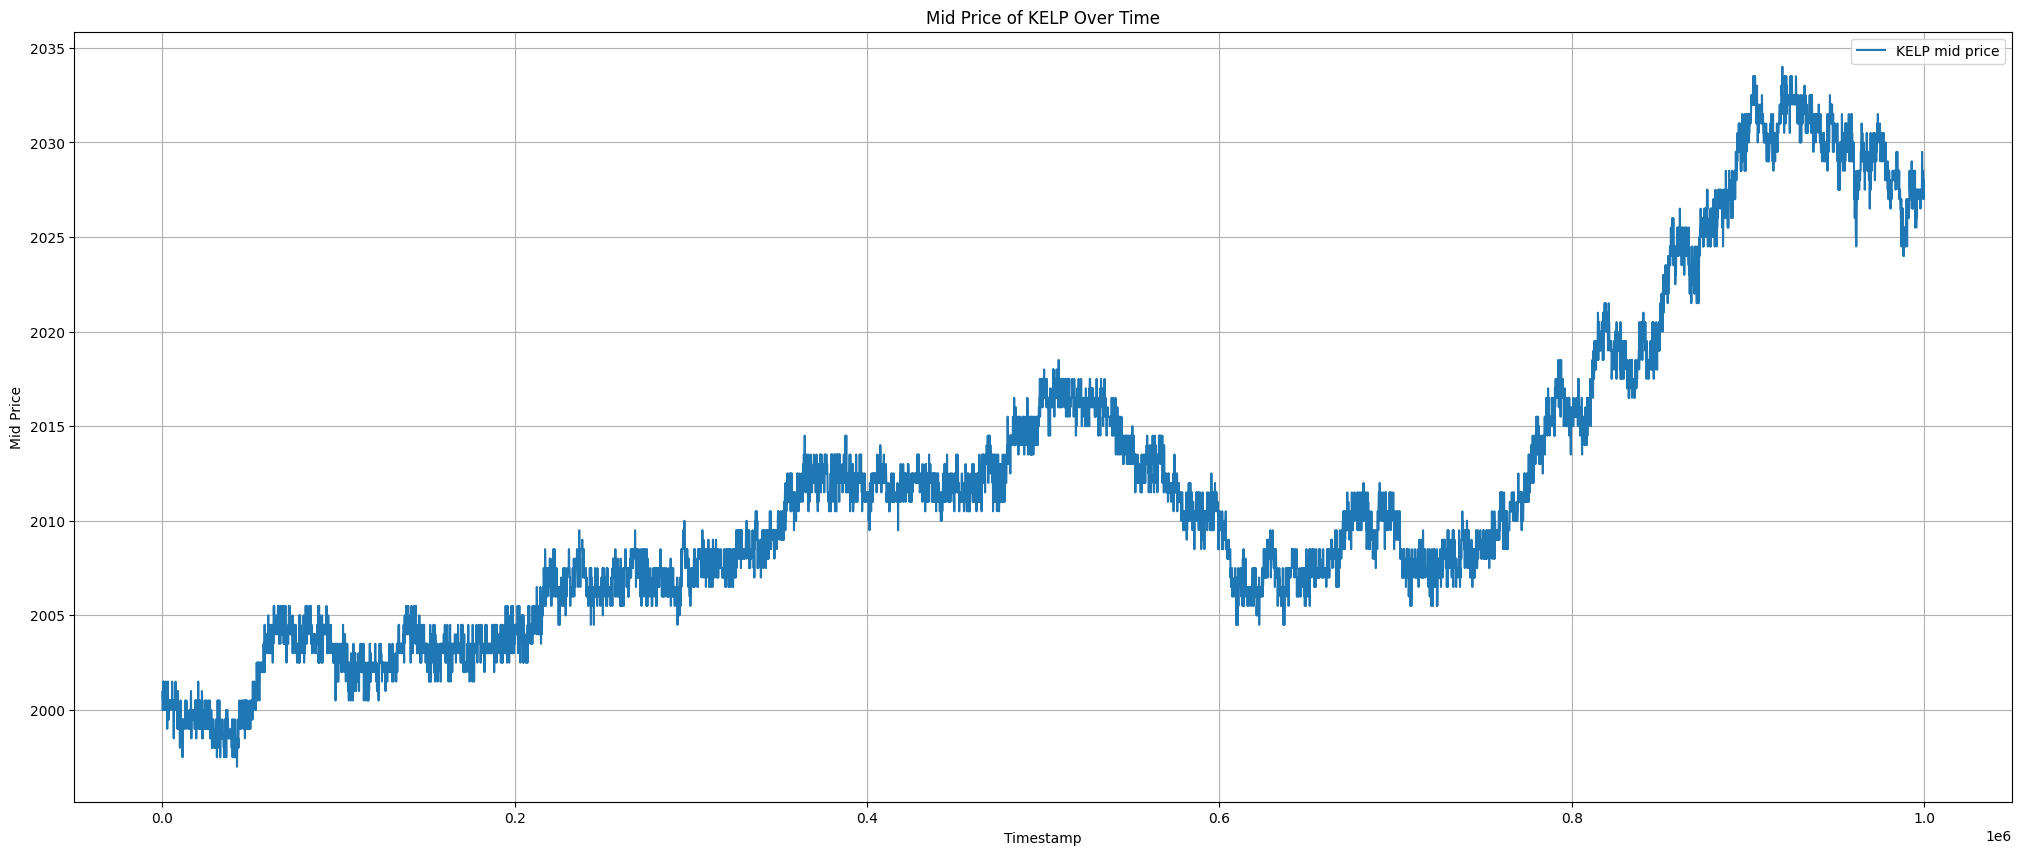

In [26]:
prices.sort_values(["product", "timestamp"], inplace=True)
kelp = prices[prices["product"] == "KELP"].sort_values("timestamp")
fig = plt.figure(figsize=(25, 10))
plt.plot(kelp["timestamp"], kelp["mid_price"], label="KELP mid price")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.title("Mid Price of KELP Over Time")
plt.legend()
plt.grid(True)
plt.show()

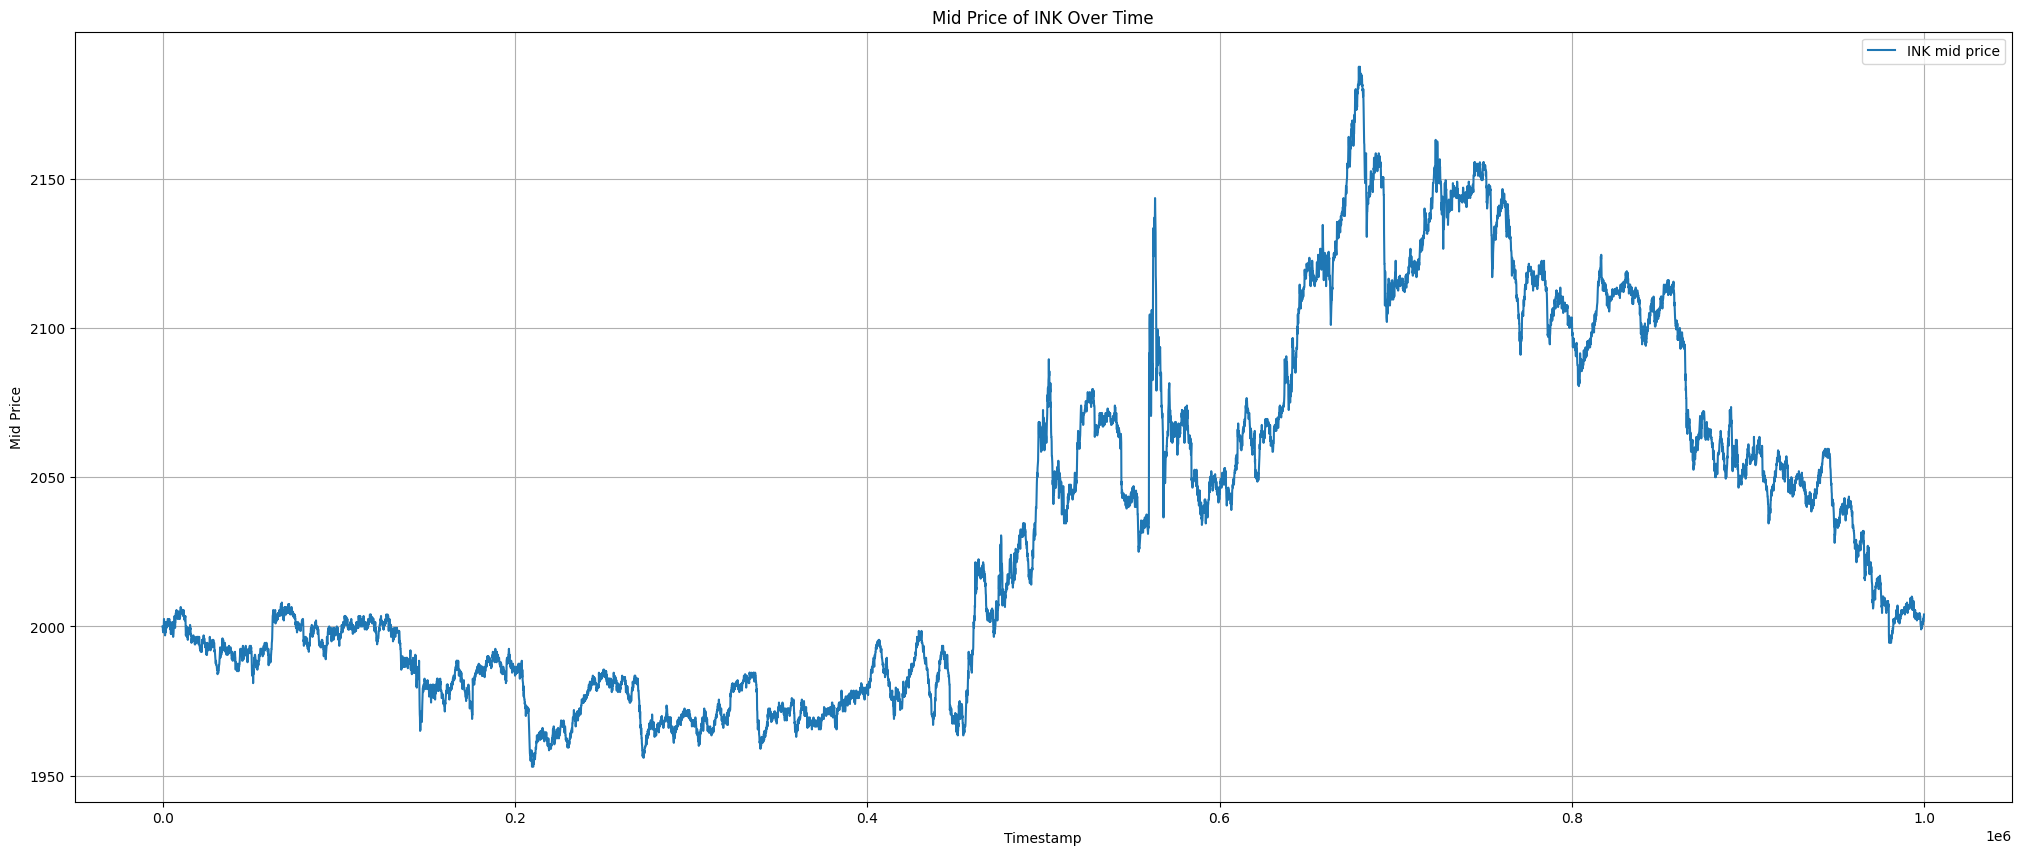

In [38]:
ink = prices[prices["product"] == "SQUID_INK"].sort_values("timestamp")
fig = plt.figure(figsize=(25, 10))
plt.plot(ink["timestamp"], ink["mid_price"], label="INK mid price")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.title("Mid Price of INK Over Time")
plt.legend()
plt.grid(True)
plt.show()

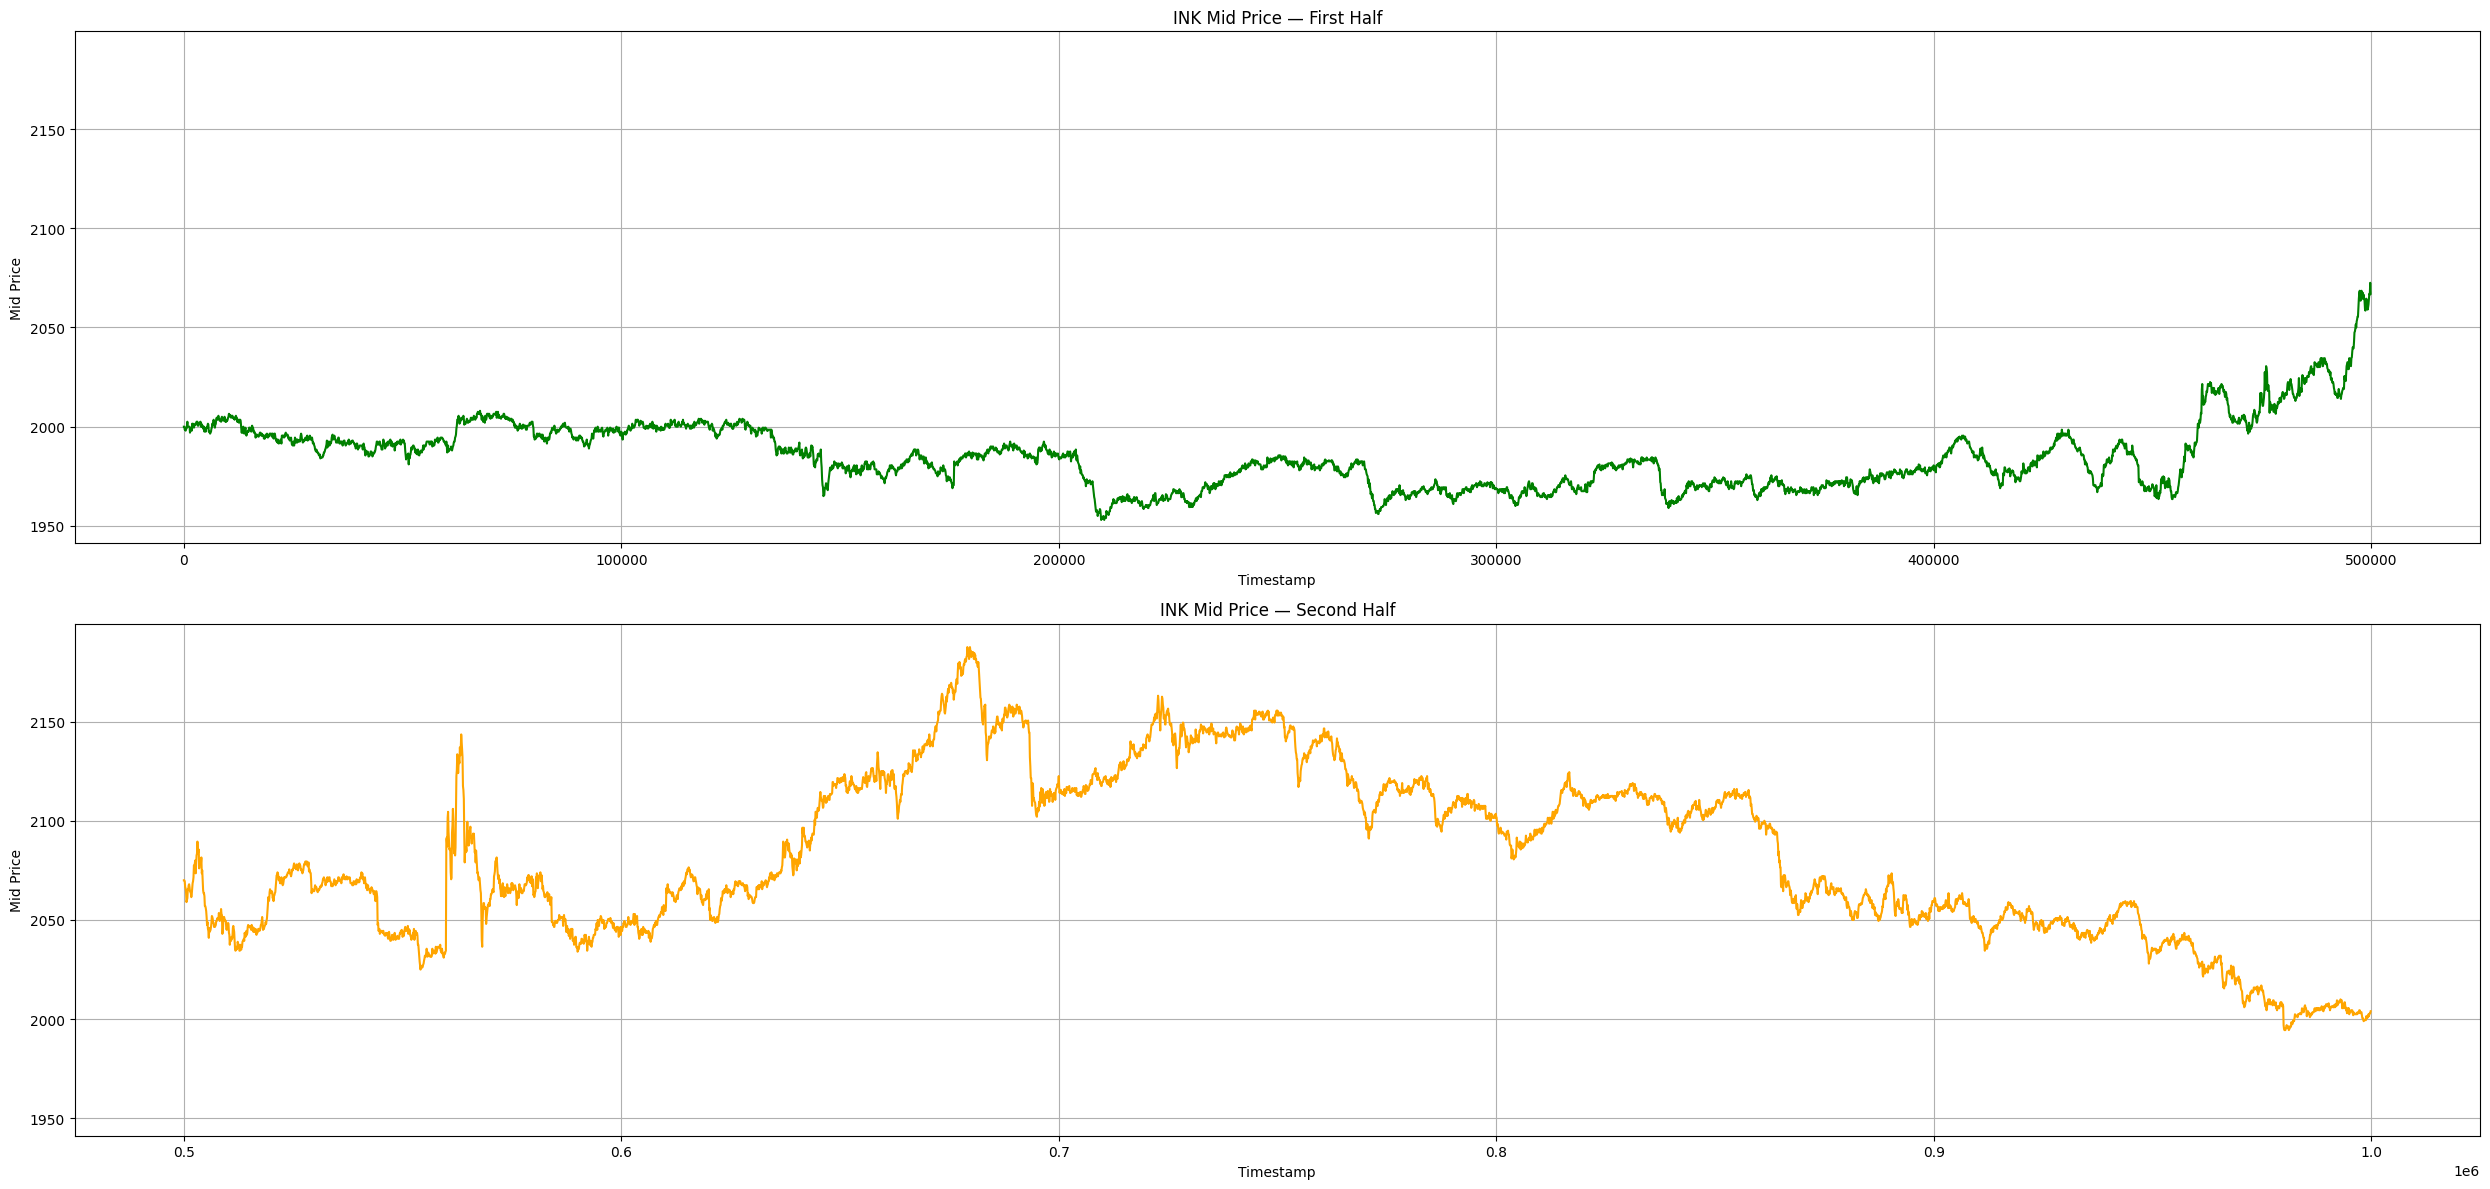

In [39]:
mid_index = len(ink) // 2
ink_first_half = ink.iloc[:mid_index]
ink_second_half = ink.iloc[mid_index:]

# Построим графики
fig, axs = plt.subplots(2, 1, figsize=(25, 12), sharey=True)

# Первая половина
axs[0].plot(ink_first_half["timestamp"], ink_first_half["mid_price"], color='green')
axs[0].set_title("INK Mid Price — First Half")
axs[0].set_xlabel("Timestamp")
axs[0].set_ylabel("Mid Price")
axs[0].grid(True)

# Вторая половина
axs[1].plot(ink_second_half["timestamp"], ink_second_half["mid_price"], color='orange')
axs[1].set_title("INK Mid Price — Second Half")
axs[1].set_xlabel("Timestamp")
axs[1].set_ylabel("Mid Price")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [33]:
prices = pd.read_csv("/Users/lenakutsak/Desktop/example-program/data/round_1/prices_round_1_day_-1.csv", delimiter=';')

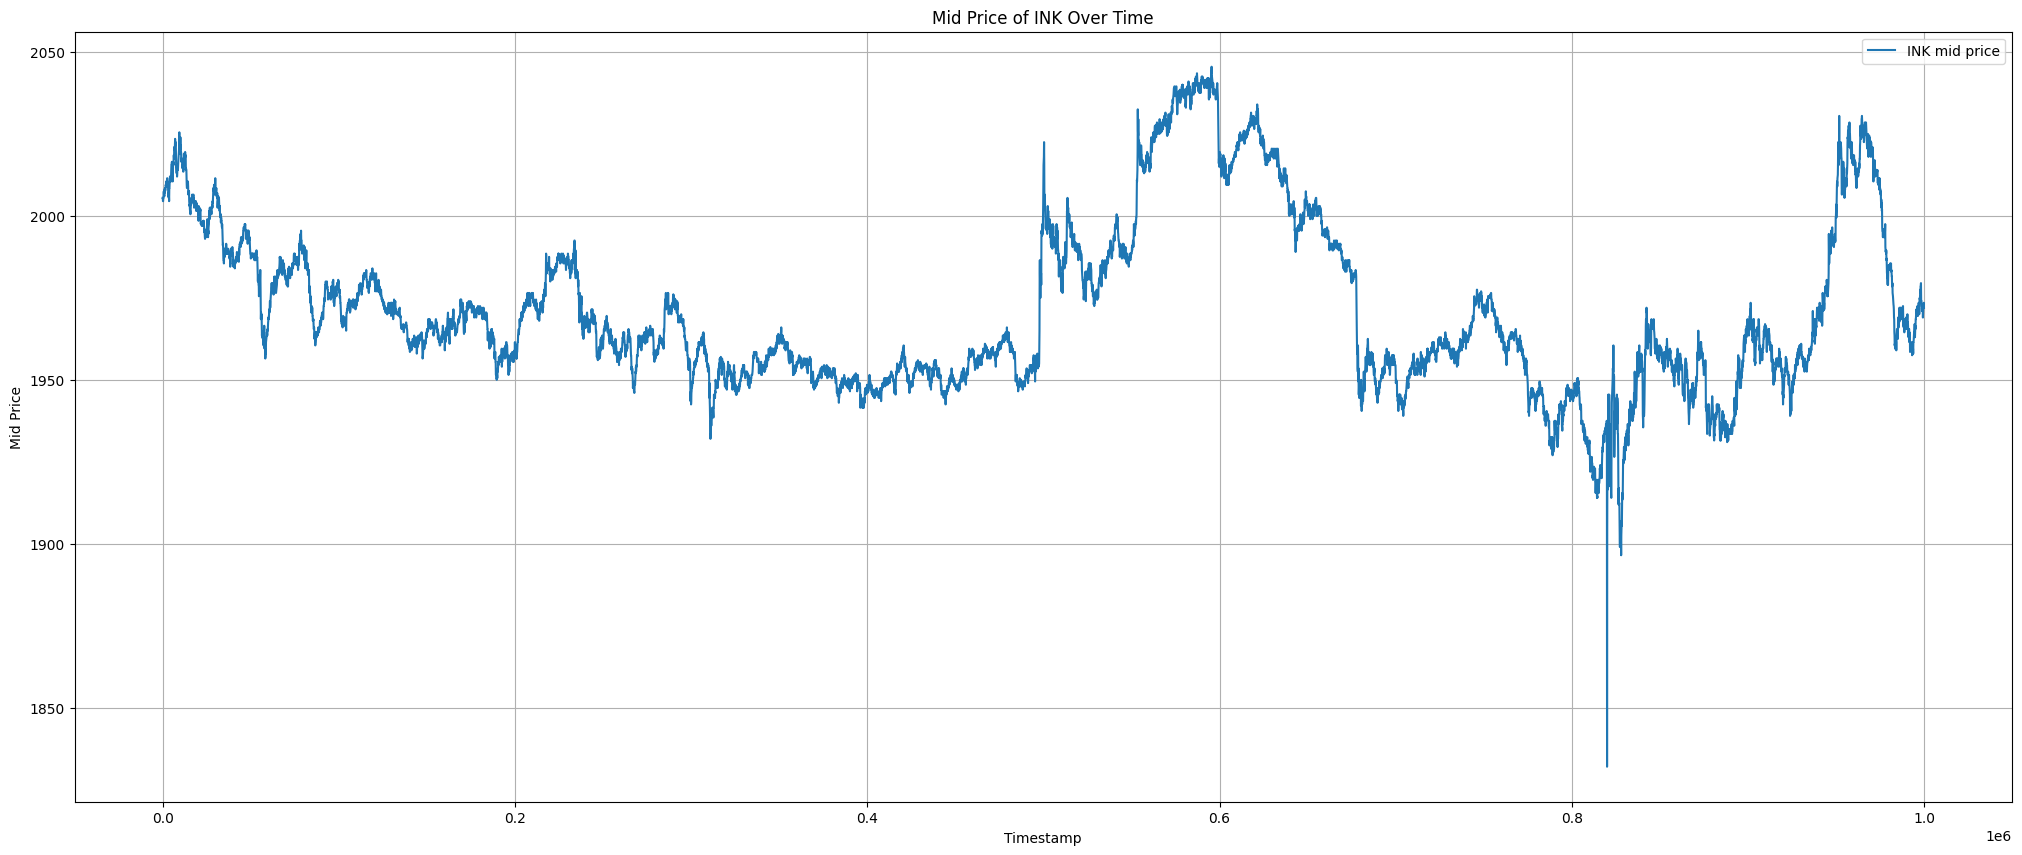

In [35]:
ink = prices[prices["product"] == "SQUID_INK"].sort_values("timestamp")
fig = plt.figure(figsize=(25, 10))
plt.plot(ink["timestamp"], ink["mid_price"], label="INK mid price")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.title("Mid Price of INK Over Time")
plt.legend()
plt.grid(True)
plt.show()

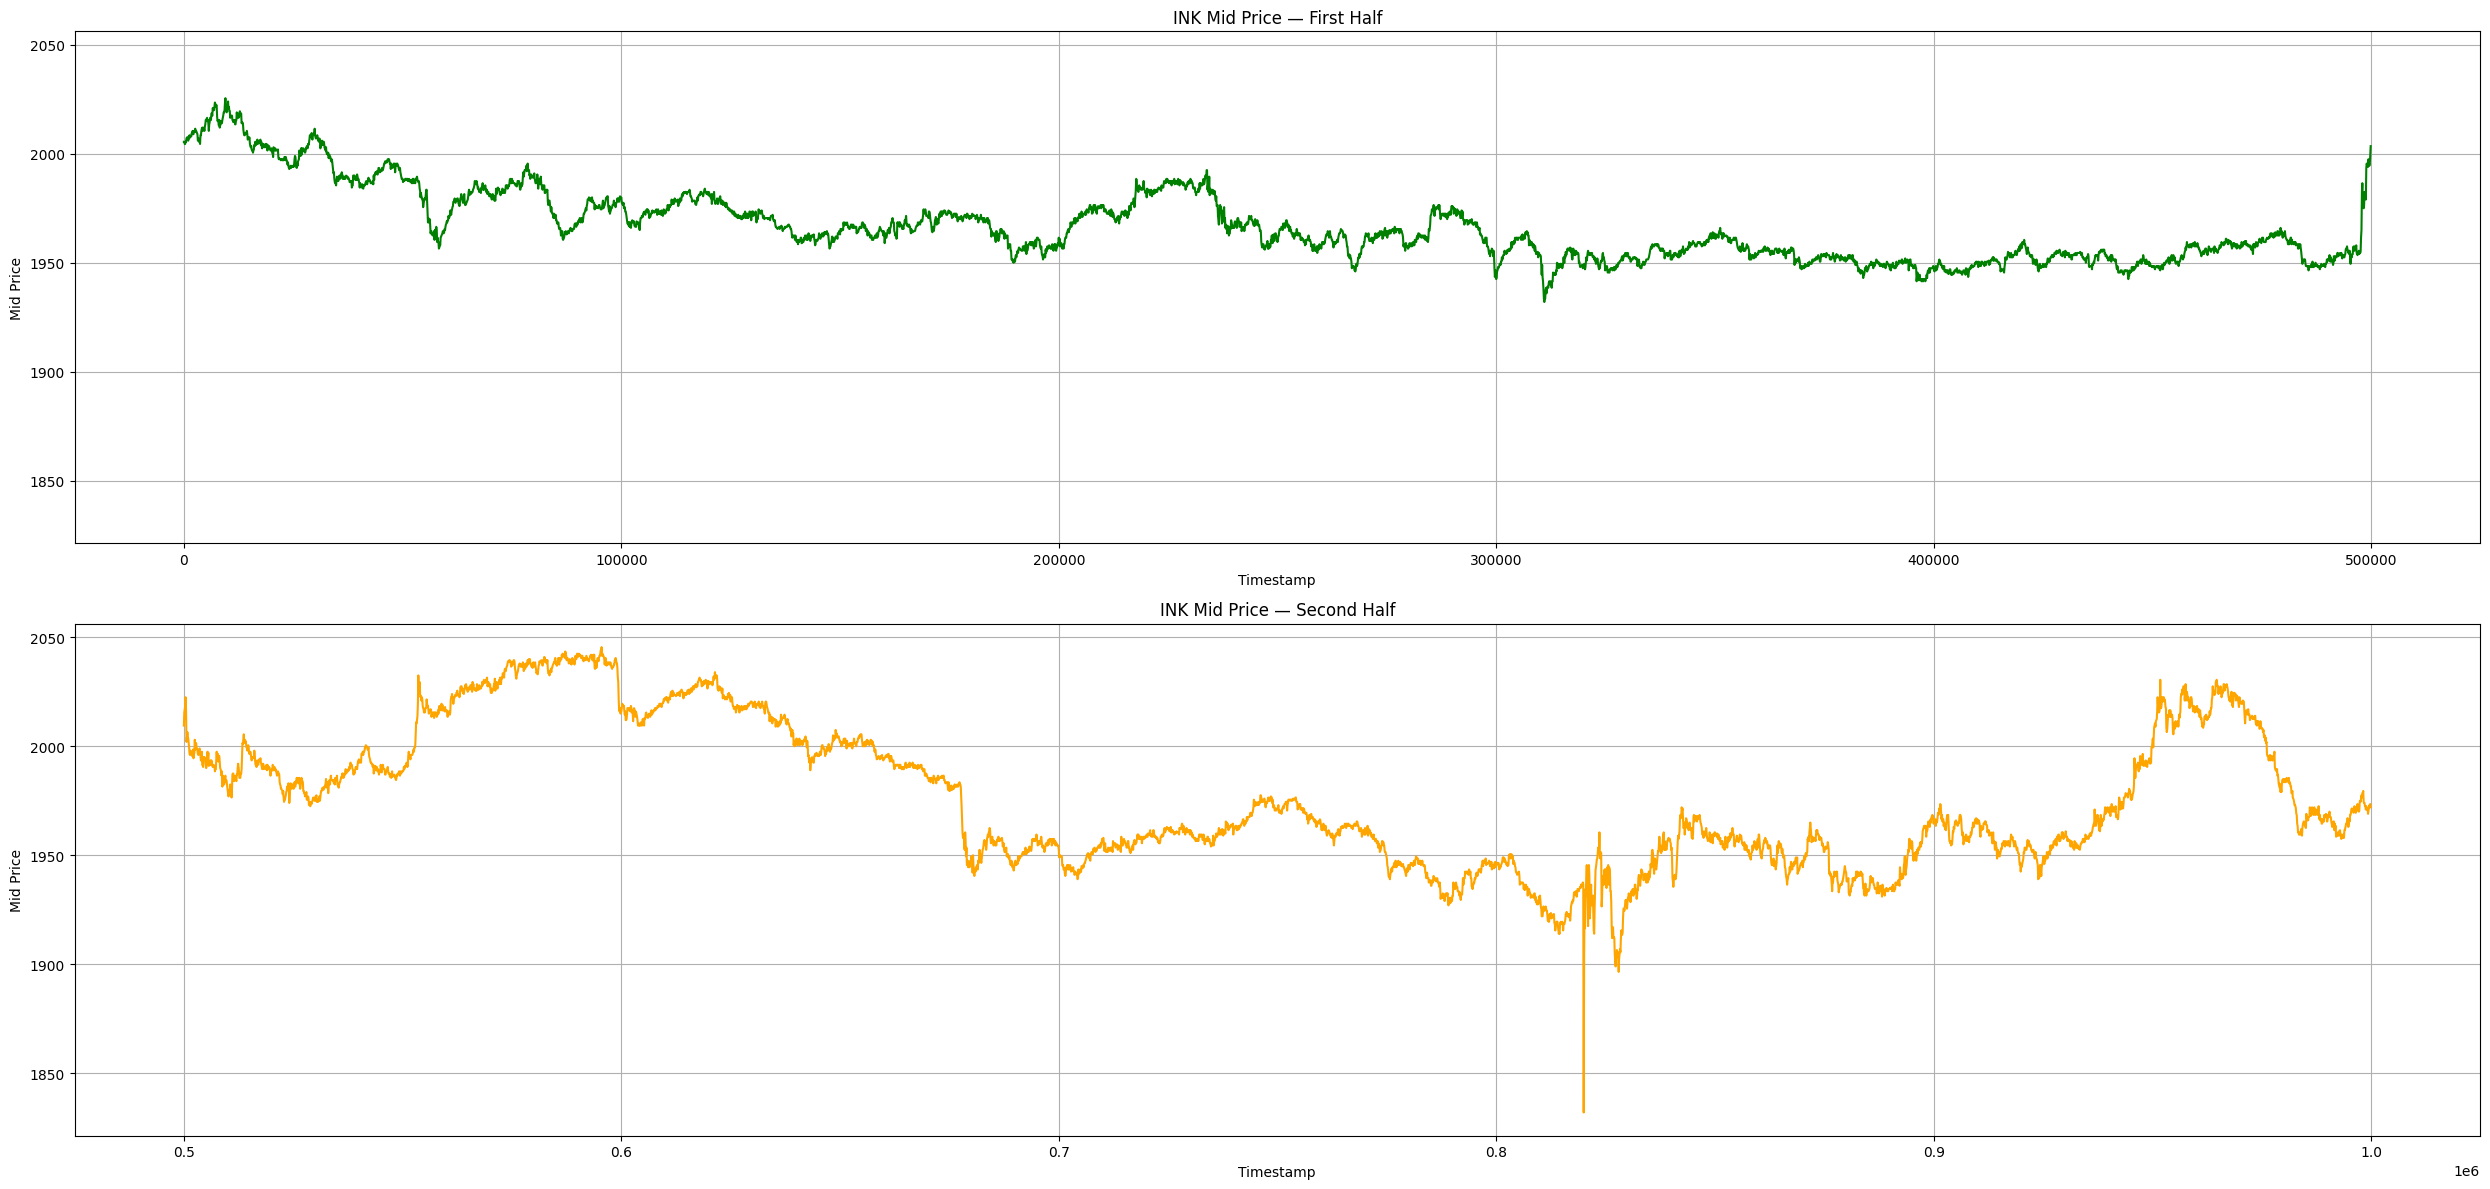

In [36]:
mid_index = len(ink) // 2
ink_first_half = ink.iloc[:mid_index]
ink_second_half = ink.iloc[mid_index:]

# Построим графики
fig, axs = plt.subplots(2, 1, figsize=(25, 12), sharey=True)

# Первая половина
axs[0].plot(ink_first_half["timestamp"], ink_first_half["mid_price"], color='green')
axs[0].set_title("INK Mid Price — First Half")
axs[0].set_xlabel("Timestamp")
axs[0].set_ylabel("Mid Price")
axs[0].grid(True)

# Вторая половина
axs[1].plot(ink_second_half["timestamp"], ink_second_half["mid_price"], color='orange')
axs[1].set_title("INK Mid Price — Second Half")
axs[1].set_xlabel("Timestamp")
axs[1].set_ylabel("Mid Price")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [30]:
prices = pd.read_csv("/Users/lenakutsak/Desktop/example-program/data/round_1/prices_round_1_day_0.csv", delimiter=';')

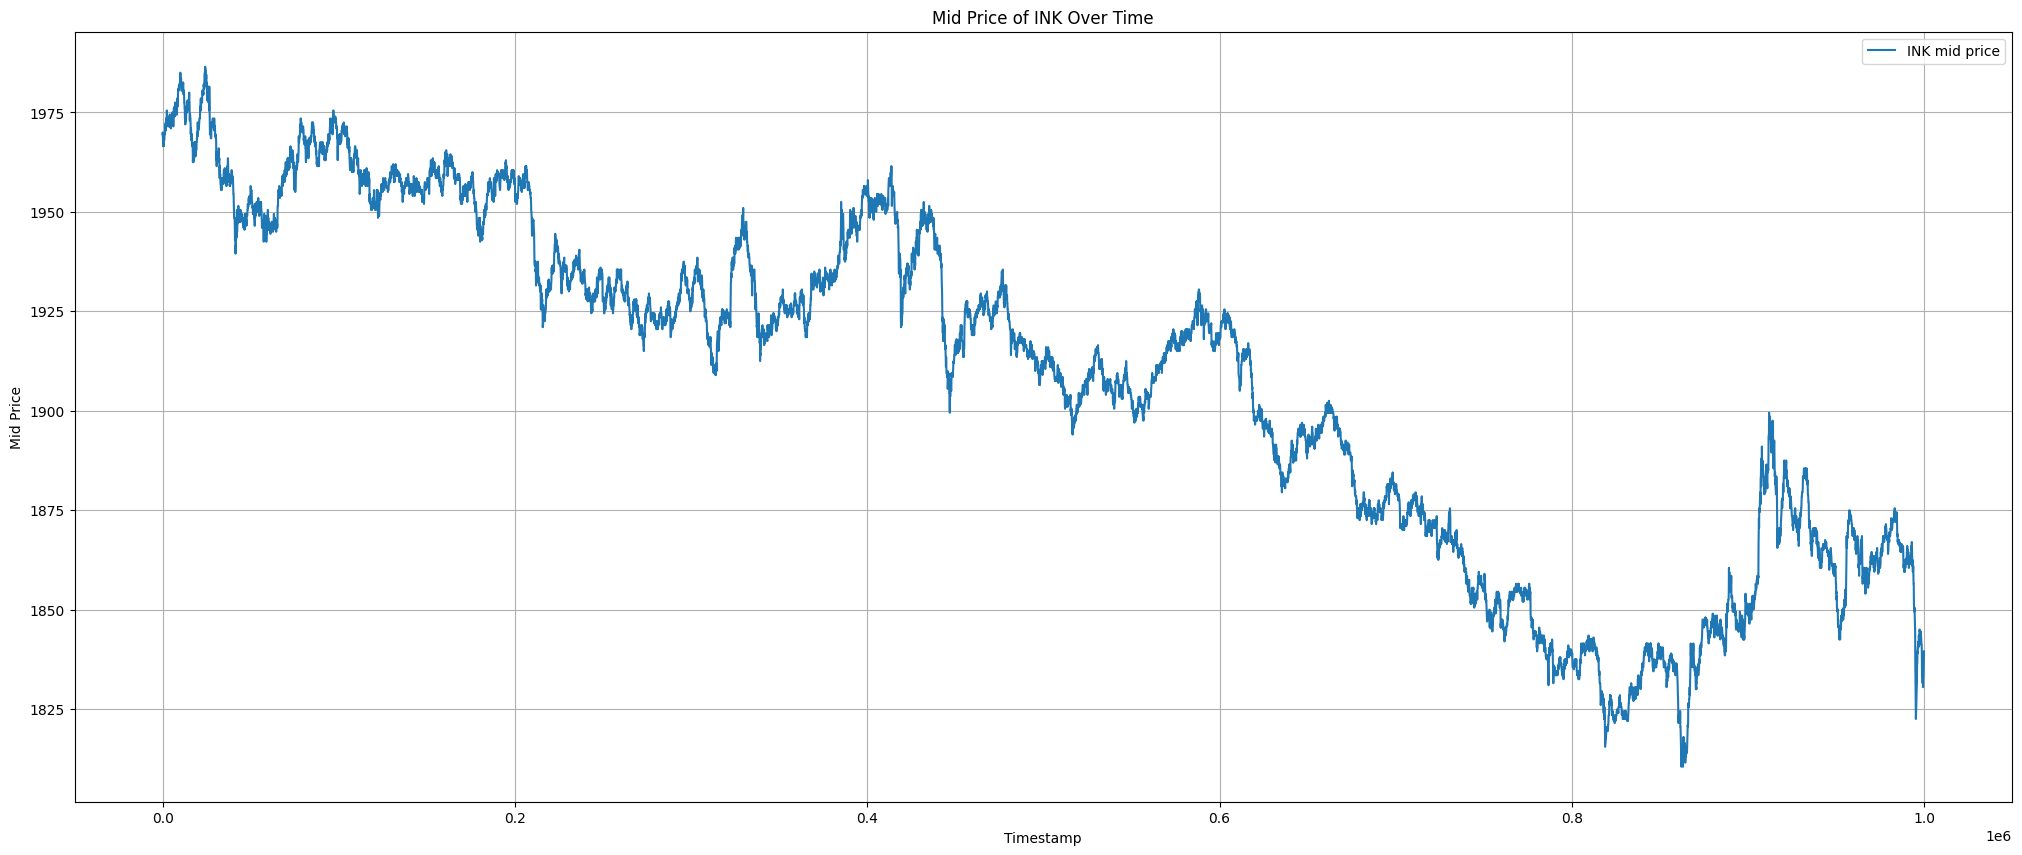

In [31]:
ink = prices[prices["product"] == "SQUID_INK"].sort_values("timestamp")
fig = plt.figure(figsize=(25, 10))
plt.plot(ink["timestamp"], ink["mid_price"], label="INK mid price")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.title("Mid Price of INK Over Time")
plt.legend()
plt.grid(True)
plt.show()

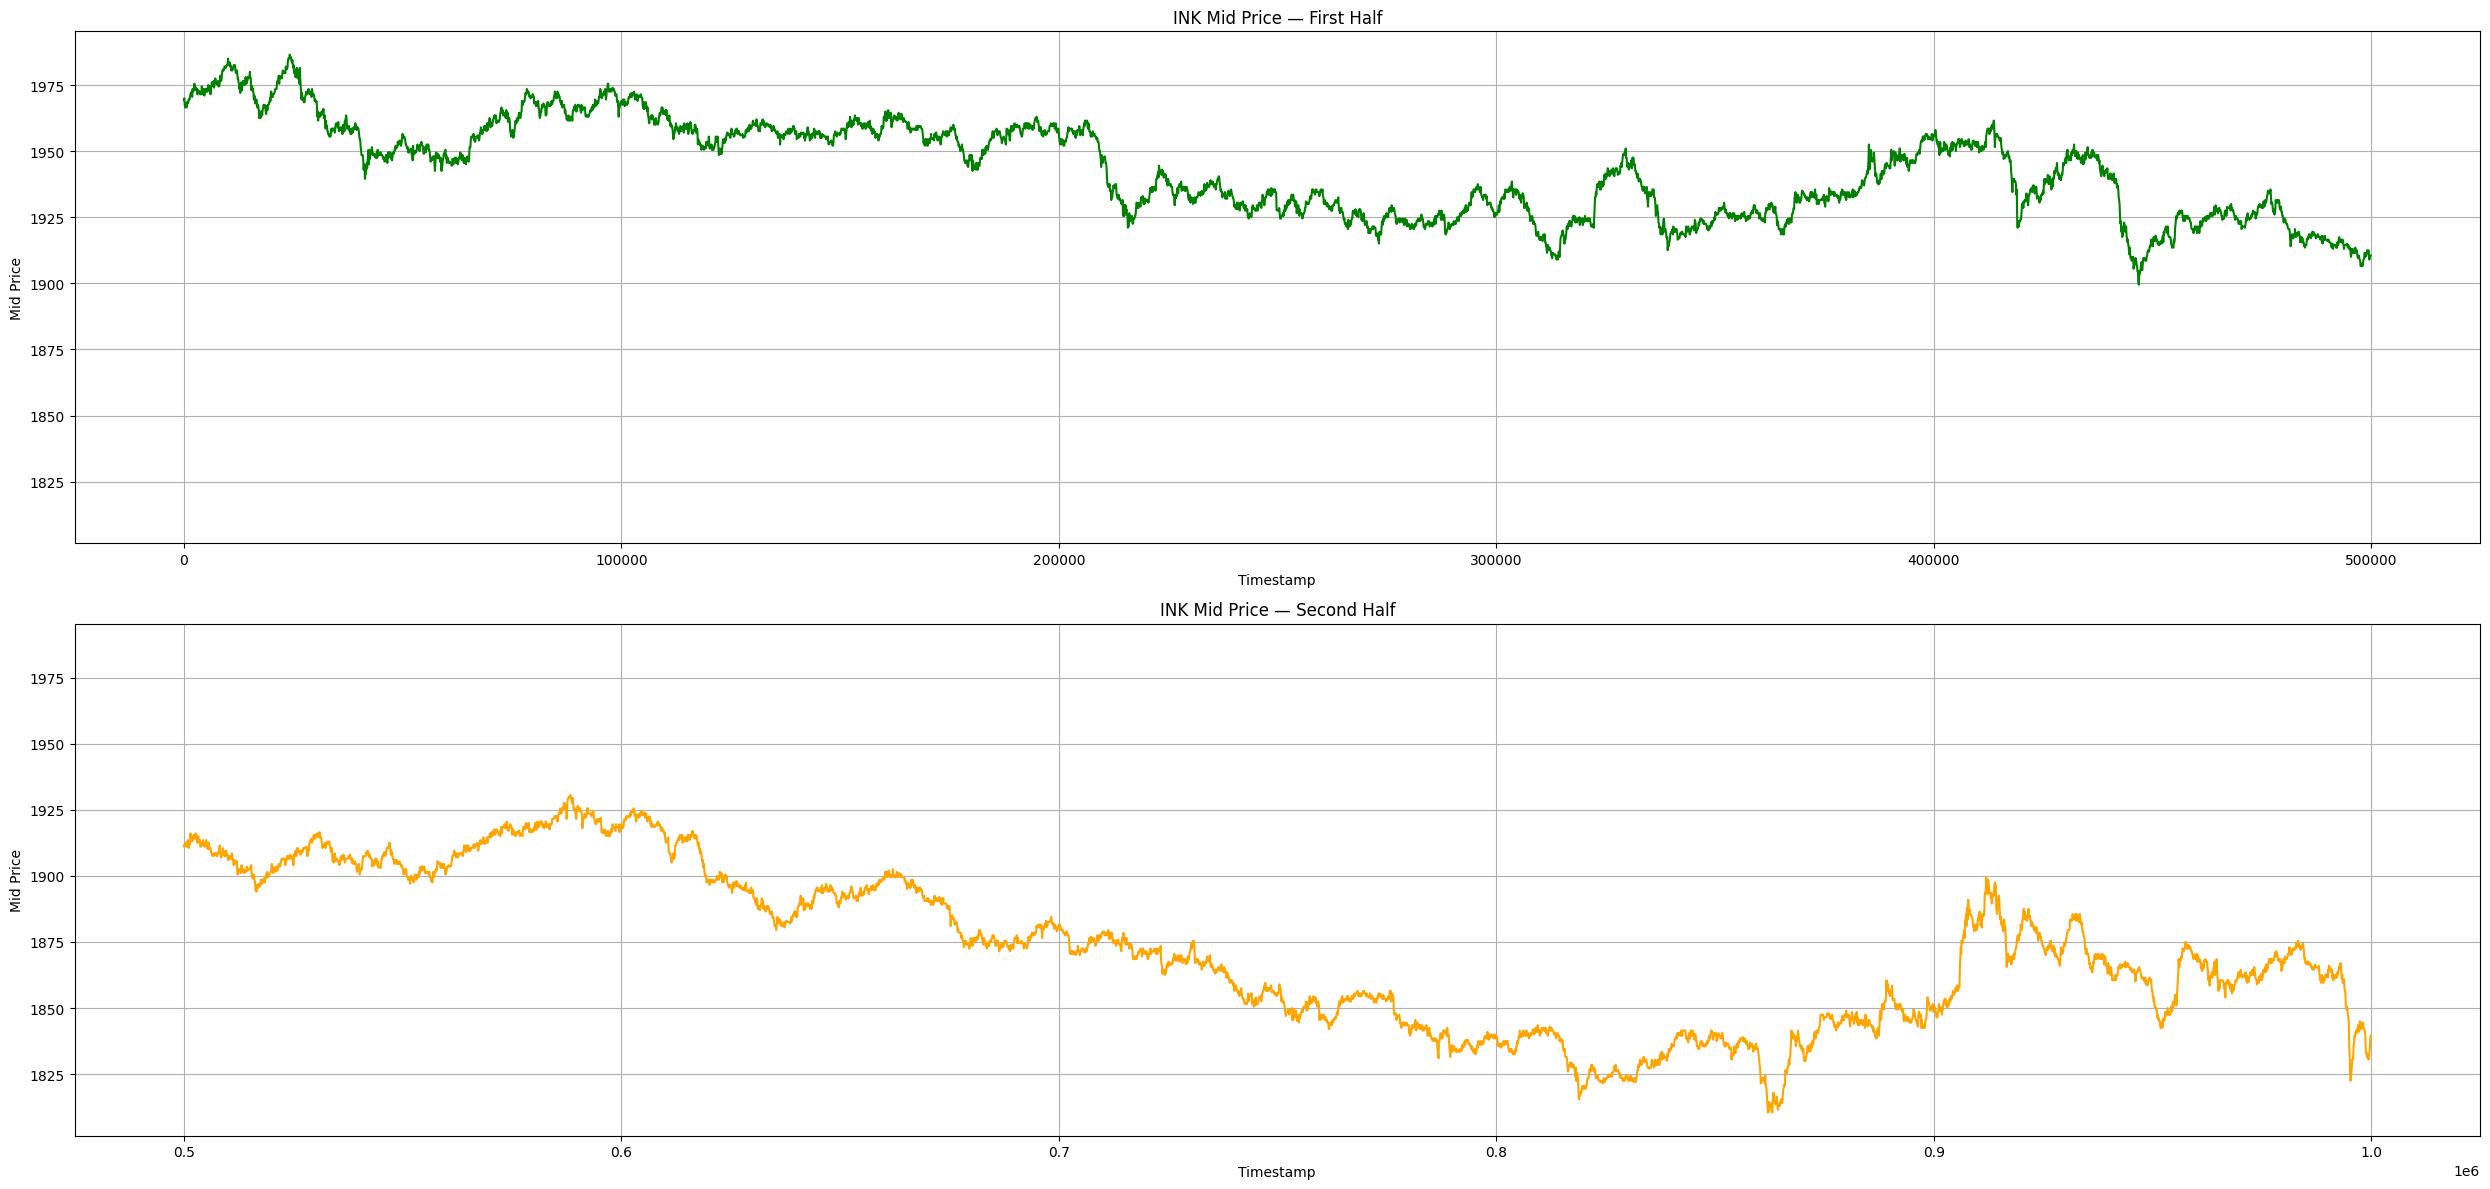

In [32]:
mid_index = len(ink) // 2
ink_first_half = ink.iloc[:mid_index]
ink_second_half = ink.iloc[mid_index:]

# Построим графики
fig, axs = plt.subplots(2, 1, figsize=(25, 12), sharey=True)

# Первая половина
axs[0].plot(ink_first_half["timestamp"], ink_first_half["mid_price"], color='green')
axs[0].set_title("INK Mid Price — First Half")
axs[0].set_xlabel("Timestamp")
axs[0].set_ylabel("Mid Price")
axs[0].grid(True)

# Вторая половина
axs[1].plot(ink_second_half["timestamp"], ink_second_half["mid_price"], color='orange')
axs[1].set_title("INK Mid Price — Second Half")
axs[1].set_xlabel("Timestamp")
axs[1].set_ylabel("Mid Price")
axs[1].grid(True)

plt.tight_layout()
plt.show()
